<a href="https://colab.research.google.com/github/DiasKhalniyasov/Early-Exit-model-on-MNIST-data/blob/main/Copy_of_NNDS_Homework_2_Template_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: Dias Khalniyasov

**Matricola**: 1954228

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

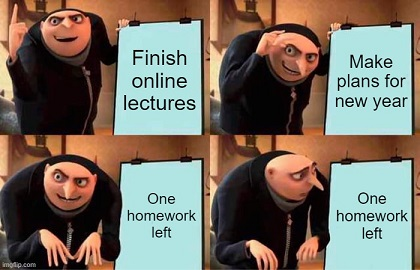

In [ ]:
import tensorflow as tf

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

In [ ]:
!pip install pydub librosa kaggle datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
import tensorflow_datasets as tfds
test_set, valid_set, train_set = tfds.load("caltech101",split=["test", "train[0%:20%]", "train[20%:]"],
                                           as_supervised=True)

In [ ]:
def format_example(image, label):
    # image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (256, 256))
    return image, label


batch_size = 32

train_set = train_set.map(format_example).shuffle(buffer_size=1024)
valid_set = valid_set.map(format_example).shuffle(buffer_size=1024)
test_set = test_set.map(format_example)

In [ ]:
ds_train_batch = train_set.prefetch(buffer_size=tf.data.AUTOTUNE).batch(32)
ds_test_batch = test_set.prefetch(buffer_size=tf.data.AUTOTUNE).batch(32)
ds_val_batch = valid_set.prefetch(buffer_size=tf.data.AUTOTUNE).batch(32)


In [ ]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

input = tf.keras.layers.Input(shape=(256,256,3))
layer =     tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu)(input)
layer =     tf.keras.layers.MaxPool2D(2, 2)(layer)

layer =     tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu)(layer)
layer =     tf.keras.layers.MaxPool2D( 2, 2)(layer)


layer =     tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu)(layer)
layer =     tf.keras.layers.MaxPool2D(2, 2)(layer)

layer =     tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu)(layer)
layer =     tf.keras.layers.MaxPool2D( 2, 2)(layer)
layer =     tf.keras.layers.Flatten()(layer)
layer =     tf.keras.layers.Dense(1024)(layer)
out =     tf.keras.layers.Dense(102,activation='softmax')(layer)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

model=Model(inputs=input, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496 

In [ ]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=[train_acc_metric])

history = model.fit(ds_train_batch, epochs=5,
                    validation_data=ds_val_batch)
test_loss, test_acc = model.evaluate(ds_test_batch, verbose=2)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


77/77 [==============================] - 23s 128ms/step - loss: 4.5125 - sparse_categorical_accuracy: 0.0474 - val_loss: 4.3137 - val_sparse_categorical_accuracy: 0.0833
Epoch 2/5
77/77 [==============================] - 11s 111ms/step - loss: 3.7389 - sparse_categorical_accuracy: 0.1895 - val_loss: 3.6577 - val_sparse_categorical_accuracy: 0.2320
Epoch 3/5
77/77 [==============================] - 7s 79ms/step - loss: 2.2350 - sparse_categorical_accuracy: 0.4657 - val_loss: 3.9022 - val_sparse_categorical_accuracy: 0.2794
Epoch 4/5
77/77 [==============================] - 7s 82ms/step - loss: 1.0436 - sparse_categorical_accuracy: 0.7324 - val_loss: 5.0193 - val_sparse_categorical_accuracy: 0.2516
Epoch 5/5
77/77 [==============================] - 7s 78ms/step - loss: 0.4893 - sparse_categorical_accuracy: 0.8815 - val_loss: 5.6375 - val_sparse_categorical_accuracy: 0.2516
191/191 - 10s - loss: 4.1234 - sparse_categorical_accuracy: 0.3836 - 10s/epoch - 52ms/step


In [ ]:
print(test_acc, test_loss)

0.3836292028427124 4.123401165008545


In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[train_acc_metric])

history = model.fit(ds_train_batch, epochs=20,
                    validation_data=ds_val_batch)
test_loss, test_acc = model.evaluate(ds_test_batch, verbose=2)
print(test_acc, test_loss)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


77/77 [==============================] - 18s 144ms/step - loss: 4.6294 - sparse_categorical_accuracy: 0.0127 - val_loss: 4.6237 - val_sparse_categorical_accuracy: 0.0082
Epoch 2/20
77/77 [==============================] - 9s 96ms/step - loss: 4.6191 - sparse_categorical_accuracy: 0.0110 - val_loss: 4.6223 - val_sparse_categorical_accuracy: 0.0131
Epoch 3/20
77/77 [==============================] - 8s 94ms/step - loss: 4.6100 - sparse_categorical_accuracy: 0.0159 - val_loss: 4.6188 - val_sparse_categorical_accuracy: 0.0065
Epoch 4/20
77/77 [==============================] - 11s 116ms/step - loss: 4.5955 - sparse_categorical_accuracy: 0.0212 - val_loss: 4.6139 - val_sparse_categorical_accuracy: 0.0147
Epoch 5/20
77/77 [==============================] - 8s 97ms/step - loss: 4.5685 - sparse_categorical_accuracy: 0.0261 - val_loss: 4.5865 - val_sparse_categorical_accuracy: 0.0196
Epoch 6/20
77/77 [==============================] - 6s 74ms/step - loss: 4.5083 - sparse_categorical_accuracy: 0

In [ ]:
# SGD with lr = 1e-2 after 20 epochs: test = 44%
# Adam after 5 epochs: test = 38%

In [ ]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)
features, labels = next(iter(ds_train_batch))

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 4.622300148010254


In [ ]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 40

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  epoch_valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()


  # Training loop - using batches of 32
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_train_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_train_accuracy.result())
    
  valid_loss = 0
  for x, y in ds_val_batch:
    # forward pass in inference mode
    # logits = model(x, training=False)
    # cumulate validation loss
    valid_loss += loss(model, x, y, training=False)
    epoch_valid_accuracy.update_state(y, model(x, training=False))

  if epoch % 5 == 0:
    print("Epoch {:03d}: Training Loss: {:.3f}, Accuracy: {:.3%}, Validation Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_train_accuracy.result(),
                                                                epoch_valid_accuracy.result()))

Epoch 000: Training Loss: 4.630, Accuracy: 1.225%, Validation Accuracy: 1.307%
Epoch 005: Training Loss: 4.594, Accuracy: 1.430%, Validation Accuracy: 0.654%
Epoch 010: Training Loss: 4.523, Accuracy: 6.168%, Validation Accuracy: 3.105%
Epoch 015: Training Loss: 4.202, Accuracy: 21.201%, Validation Accuracy: 7.353%
Epoch 020: Training Loss: 3.782, Accuracy: 33.456%, Validation Accuracy: 9.967%
Epoch 025: Training Loss: 3.417, Accuracy: 43.015%, Validation Accuracy: 11.601%
Epoch 030: Training Loss: 3.074, Accuracy: 51.185%, Validation Accuracy: 10.948%
Epoch 035: Training Loss: 2.716, Accuracy: 59.681%, Validation Accuracy: 10.458%


In [ ]:
print("Epoch {:03d}: Training Loss: {:.3f}, Accuracy: {:.3%}, Validation Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_train_accuracy.result(),
                                                                epoch_valid_accuracy.result()))

Epoch 039: Training Loss: 2.420, Accuracy: 66.095%, Validation Accuracy: 14.542%


In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in ds_test_batch:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.math.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 28.912%


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
model.save_weights('/content/gdrive/MyDrive/checkpoints/my_checkpoint')


In [ ]:
# Test Accuracy 28.9, now lets modify model

In [ ]:
# An EarlyExit layer
class EarlyExit(keras.layers.Layer):
    def __init__(self):
        super(EarlyExit, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(102,activation='softmax')
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense(x)
        return x

class EE_loss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred-y_true))
    rmse = tf.math.sqrt(mse)
    return rmse / tf.reduce_mean(tf.square(y_true)) - 1

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Activation
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

inputs = tf.keras.layers.Input(shape=(256,256,3))
x =     tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu)(inputs)
x =     tf.keras.layers.MaxPool2D(2, 2)(x)

EE_1 = EarlyExit()(x)
EE_out_1 = EE_loss(y,EE_1)
# if self._calculate_max_activation( exit1 ) > self.beta * self.activation_threshold_1:
#             self.num_early_exit_1 += 1
#             return 0, exit1

x =     tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu)(x)
x =     tf.keras.layers.MaxPool2D( 2, 2)(x)

EE_2 = EarlyExit()(x)

x =     tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu)(x)
x =     tf.keras.layers.MaxPool2D(2, 2)(x)

EE_3 = EarlyExit()(x)

x =     tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu)(x)
x =     tf.keras.layers.MaxPool2D( 2, 2)(x)
x =     tf.keras.layers.Flatten()(x)
x =     tf.keras.layers.Dense(1024)(x)
x =     tf.keras.layers.Dense(102)(x)
x = Activation('softmax',name="final_loss")(x)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

model=Model(inputs=inputs, outputs=[x,EE_1,EE_2,EE_3])
model.summary()

Tensor("early_exit_7/activation/Softmax:0", shape=(None, 102), dtype=float32)
Tensor("early_exit_8/activation/Softmax:0", shape=(None, 102), dtype=float32)
Tensor("early_exit_9/activation/Softmax:0", shape=(None, 102), dtype=float32)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 254, 254, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                        

In [ ]:
losses = {
	"final_loss": "categorical_crossentropy",
	"early_exit_7": "categorical_crossentropy",
	"early_exit_8": "categorical_crossentropy",
	"early_exit_9": "categorical_crossentropy",

}
lossWeights = {"final_loss": 1.0, "early_exit_7": 1.0, "early_exit_8": 1.0, "early_exit_9": 1.0,}
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
model.compile(optimizer='adam', loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

history = model.fit(ds_train_batch, epochs=5,
                    validation_data=ds_val_batch)
test_loss, test_acc = model.evaluate(ds_test_batch, verbose=2)

[INFO] compiling model...
Epoch 1/5
Tensor("model_2/early_exit_9/activation/Softmax:0", shape=(None, 102), dtype=float32)
Tensor("model_2/early_exit_8/activation_1/Softmax:0", shape=(None, 102), dtype=float32)
Tensor("model_2/early_exit_7/activation_2/Softmax:0", shape=(None, 102), dtype=float32)


ValueError: ignored

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
        # Add any extra losses created during the forward pass.
        loss_value += sum(model.losses)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[train_acc_metric])

history = model.fit(ds_train_batch, epochs=20,
                    validation_data=ds_val_batch)
test_loss, test_acc = model.evaluate(ds_test_batch, verbose=2)
print(test_acc, test_loss)

Epoch 1/20


ValueError: ignored

In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, **kwargs):
        kwargs.setdefault("name", "custom_model")
        super().__init__(**kwargs)
        self.input = tf.keras.layers.InputLayer(input_shape=(256,256,3))
        self.conv2d_32 = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu)
        self.maxpool = tf.keras.layers.MaxPool2D(2, 2)
        self.conv2d_64 = tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu)
        self.dense = tf.keras.layers.Dense(1024)
        self.class_layer = tf.keras.layers.Dense(102,activation='softmax')
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    @property
    def metrics(self):
        # Automatically resets the metric states at the start of each epoch or at the start of evaluate()
        return [self.loss_tracker]

    def loss_fn(self, features, label):
        # custom loss: sum of losses of early exit blocks
        
        pass

    def train_step(self, data):
        x, y = data
        y = tf.reshape(tf.cast(y, tf.float32), shape=(-1, 1))  # (batch_size x 1)
        if not self.logistic.trainable_weights:
            _ = self(x)  # required to initialize layer parameters with build() method
        with tf.GradientTape() as tape:
            loss = self.loss_fn(x, y)
        grads = tape.gradient(loss, self.trainable_weights)
        # Tell the optimizer to apply gradients on specified variables
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update the running loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def call(self, inputs):
        logistic_input = self.nn_block(inputs) if self.nn_block else inputs
        return self.logistic(logistic_input)

### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

In [ ]:
# TODO: add the model definition and model training code here (as many cells as you need).
model = ...

In [ ]:
# You can train using fit() or a custom training loop, equivalently.

✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

In [ ]:
# TODO: add metrics and/or graphs showing the model was trained correctly.

### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the model (what you implemented, bibliographic references, how you are training it, notable implementation issues, etc.).*

**TODO**: add a complete description here (2-3 paragraphs).

In [ ]:
# TODO: add all code here, using as many cells as you need. Train the new model.

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

In [ ]:
# TODO: Add results here (anything appropriate is okay).

### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the regularization term you implemented.*

**TODO**: add description (1-2 paragraphs).

In [ ]:
# TODO: add code here. Train again the model with the new regularization loss.

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*

In [ ]:
# TODO: Add results here (anything appropriate is okay).

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

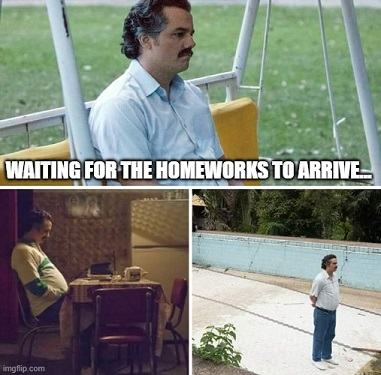